In [23]:
import sys
sys.path.append("../scripts")
from kf import *

In [36]:
def make_ax():
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(111)
    ax.set_aspect("equal")
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_xlabel("X", fontsize=10)
    ax.set_ylabel("Y", fontsize=10)
    return ax

def draw_trajectory(xs, ax):
    poses = [xs[s] for s in range(len(xs))]
    ax.scatter([e[0] for e in poses], [e[1] for e in poses], s=5, marker=".", color="black")
    ax.plot([e[0] for e in poses], [e[1] for e in poses], linewidth=0.5, color="black")
    
def draw_observations(xs, zlist, ax):
    for s in range(len(xs)):
        if s not in zlist:
            continue
    
        for obs in zlist[s]:
            x, y, theta = xs[s]
            ell, phi = obs[1][0], obs[1][1]
            mx = x + ell*math.cos(theta + phi)
            my = y + ell*math.sin(theta + phi)
            ax.plot([x, mx], [y, my], color="pink", alpha=0.5)
            
def draw_edges(edges, ax):
    for e in edges:
        ax.plot([e.x1[0], e.x2[0]], [e.x1[1], e.x2[1]], color="red", alpha=0.5)

def draw_landmarks(ms, ax):
    ax.scatter([ms[k][0] for k in ms], [ms[k][1] for k in ms], s=100, marker="*", color="blue", zorder=100)
    
def draw(xs, zlist, edges, ms=[]):
    ax = make_ax()
    draw_observations(xs, zlist, ax)
    draw_trajectory(xs, ax)
    draw_landmarks(ms, ax)
    plt.show()

In [25]:
def read_data():
    hat_xs = {}
    zlist = {}
    delta = 0.0
    us = {}
    
    with open("log2.txt") as f:
        for line in f.readlines():
            tmp = line.rstrip().split()
            
            step = int(tmp[1])
            if tmp[0] == "x":
                hat_xs[step] = np.array([float(tmp[2]), float(tmp[3]), float(tmp[4])]).T
            elif tmp[0] == "z":
                if step not in zlist:
                    zlist[step] = []
                zlist[step].append((int(tmp[2]), np.array([float(tmp[3]), float(tmp[4]), float(tmp[5])]).T))
            elif tmp[0] == "delta":
                delta = float(tmp[1])
            elif tmp[0] == "u":
                us[step] = np.array([float(tmp[2]), float(tmp[3])]).T
                
        return hat_xs, zlist, us, delta

In [26]:
class ObsEdge(object):
    def __init__(self, t1, t2, z1, z2, xs, sensor_noise_rate=[0.14, 0.05, 0.05]):
        assert z1[0] == z2[0] 

        self.t1, self.t2 = t1, t2  
        self.x1, self.x2 = xs[t1], xs[t2]
        self.z1, self.z2 = z1[1], z2[1]
        
        s1 = math.sin(self.x1[2] + self.z1[1]) 
        c1 = math.cos(self.x1[2] + self.z1[1])
        s2 = math.sin(self.x2[2] + self.z2[1])
        c2 = math.cos(self.x2[2] + self.z2[1])
        
        hat_e = self.x2 - self.x1 + np.array([
            self.z2[0]*c2 - self.z1[0]*c1, 
            self.z2[0]*s2 - self.z1[0]*s1,
            self.z2[1] - self.z2[2] - self.z1[1] + self.z1[2]
        ])
        while hat_e[2] >= math.pi: hat_e[2] -= math.pi*2
        while hat_e[2] <  -math.pi: hat_e[2] += math.pi*2
            
        Q1 = np.diag([(self.z1[0]*sensor_noise_rate[0])**2, sensor_noise_rate[1]**2, sensor_noise_rate[2]**2])
        R1 = - np.array([[c1, -self.z1[0]*s1,  0],
                        [s1,   self.z1[0]*c1, 0],
                        [   0,                      1, -1]])
        
        Q2 = np.diag([(self.z2[0]*sensor_noise_rate[0])**2, sensor_noise_rate[1]**2, sensor_noise_rate[2]**2])
        R2 = np.array([[c2, -self.z2[0]*s2, 0],
                       [s2, self.z2[0]*c2,   0],
                       [  0,                      1,  -1]])
        
        Sigma = R1.dot(Q1).dot(R1.T) + R2.dot(Q2).dot(R2.T)
        Omega = np.linalg.inv(Sigma)
        
        B1 = - np.array([[1, 0, -self.z1[0]*s1],
                        [0, 1, self.z1[0]*c1],
                        [0, 0, 1]])
        B2 = np.array([[1, 0,  -self.z2[0]*s2],
                        [0, 1,   self.z2[0]*c2],
                        [0, 0, 1]])
        
        self.omega_upperleft = B1.T.dot(Omega).dot(B1)
        self.omega_upperright = B1.T.dot(Omega).dot(B2)
        self.omega_bottomleft = B2.T.dot(Omega).dot(B1)
        self.omega_bottomright = B2.T.dot(Omega).dot(B2)
        
        self.xi_upper = - B1.T.dot(Omega).dot(hat_e)
        self.xi_bottom = - B2.T.dot(Omega).dot(hat_e)

In [27]:
class MotionEdge(object):
    def __init__(self, t1, t2, xs, us, delta, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}):
        self.t1, self.t2 = t1, t2
        self.hat_x1, self.hat_x2 = xs[t1], xs[t2]
        
        nu, omega = us[t2]
        if abs(omega) < 1e-5:
            omega = 1e-5
        
        M = matM(nu, omega, delta, motion_noise_stds)
        A = matA(nu, omega, delta, self.hat_x1[2])
        F = matF(nu, omega, delta, self.hat_x1[2])
        
        self.Omega = np.linalg.inv(A.dot(M).dot(A.T) + np.eye(3)*1e-4)
        
        self.omega_upperleft = F.T.dot(self.Omega).dot(F)
        self.omega_upperright = -F.T.dot(self.Omega)
        self.omega_bottomleft = -self.Omega.dot(F)
        self.omega_bottomright = self.Omega
        
        x2 = IdealRobot.state_transition(nu, omega, delta, self.hat_x1)
        self.xi_upper = F.T.dot(self.Omega).dot(self.hat_x2 - x2)
        self.xi_bottom = -self.Omega.dot(self.hat_x2 - x2)

In [28]:
def add_edge(edge, Omega, xi):
    f1, f2 = edge.t1*3, edge.t2*3
    t1, t2 = f1 + 3, f2 + 3
    Omega[f1:t1, f1:t1] += edge.omega_upperleft
    Omega[f1:t1, f2:t2] += edge.omega_upperright
    Omega[f2:t2, f1:t1] += edge.omega_bottomleft
    Omega[f2:t2, f2:t2] += edge.omega_bottomright
    xi[f1:t1] += edge.xi_upper
    xi[f2:t2] += edge.xi_bottom

In [29]:
import itertools
def make_edges(hat_xs, zlist):
    landmark_keys_zlist = {}

    for step in zlist:
        for z in zlist[step]:
            landmark_id = z[0]
            if landmark_id not in landmark_keys_zlist: 
                landmark_keys_zlist[landmark_id] = []

            landmark_keys_zlist[landmark_id].append((step, z))
    
    edges = []
    for landmark_id in landmark_keys_zlist:
        step_pairs = list(itertools.combinations(landmark_keys_zlist[landmark_id], 2))
        edges += [ObsEdge(xz1[0], xz2[0], xz1[1], xz2[1], hat_xs) for xz1, xz2 in step_pairs]
        
    return edges, landmark_keys_zlist

1 times iteration: 25.35425374638781
2 times iteration: 13.202890129120517
3 times iteration: 4.355823405099041
4 times iteration: 2.399645659194462
5 times iteration: 1.4452566769740838
6 times iteration: 0.8738805234778021
7 times iteration: 0.5293040286909825
8 times iteration: 0.3215853794624118
9 times iteration: 0.19619176963590246
10 times iteration: 0.12035199365199864
11 times iteration: 0.07441126650636336
12 times iteration: 0.04655215865907763
13 times iteration: 0.029647115053847987
14 times iteration: 0.01938635720533722
15 times iteration: 0.013159200828578611
16 times iteration: 0.009382011469126454


<IPython.core.display.Javascript object>


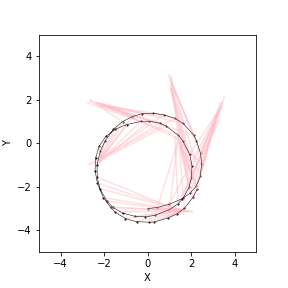

In [34]:
hat_xs, zlist, us, delta = read_data()
dim = len(hat_xs)*3

for n in range(1, 10000):
    edges, _ = make_edges(hat_xs, zlist)
    
    for i in range(len(hat_xs) - 1):
        edges.append(MotionEdge(i, i+1, hat_xs, us, delta))
    
    Omega = np.zeros((dim, dim))
    xi = np.zeros(dim)
    Omega[0:3, 0:3] += np.eye(3)*1000000
    
    for e in edges:
        add_edge(e, Omega, xi)
        
    delta_xs = np.linalg.inv(Omega).dot(xi)
    
    for i in range(len(hat_xs)):
        hat_xs[i] += delta_xs[i*3:(i+1)*3]
        
    diff = np.linalg.norm(delta_xs)
    print("{} times iteration: {}".format(n, diff))
    if diff < 0.01:
        draw(hat_xs, zlist, edges)
        break

In [31]:
_, zlist_landmark = make_edges(hat_xs, zlist)
zlist_landmark

{1: [(0, (1, array([ 1.50034871, -0.00881358,  3.20179977]))),
  (1, (1, array([ 1.29622542, -0.30814846,  3.0748203 ]))),
  (2, (1, array([ 0.69549034, -0.8437969 ,  2.78596959]))),
  (22, (1, array([3.86327258, 0.97947226, 2.86187315]))),
  (23, (1, array([4.18764781, 0.9964682 , 2.993133  ]))),
  (24, (1, array([3.66568079, 0.72591843, 3.14962214]))),
  (25, (1, array([ 3.64355799,  0.63791718, -3.05650151]))),
  (27, (1, array([ 2.27097196,  0.26793963, -2.84661133]))),
  (28, (1, array([ 1.63933754,  0.15504342, -2.89496909]))),
  (30, (1, array([ 0.64791162, -0.59893527, -3.15411536]))),
  (49, (1, array([3.94550154, 0.9605901 , 2.92354389]))),
  (50, (1, array([3.57815626, 0.94107887, 3.09264458]))),
  (51, (1, array([ 3.74657823,  0.68793635, -3.02460791]))),
  (52, (1, array([ 3.11949256,  0.72248324, -3.03331976]))),
  (53, (1, array([ 2.52981025,  0.56785297, -2.90459003]))),
  (54, (1, array([ 2.23018053,  0.3431673 , -2.78922171]))),
  (55, (1, array([ 1.57679613,  0.26245

In [32]:
class MapEdge(object):
    def __init__(self, t, z, head_t, head_z, xs):
        self.x = xs[t]
        self.z = z
        
        self.m = self.x + np.array([
            z[0]*math.cos(self.x[2] + z[1]),
            z[0]*math.sin(self.x[2] + z[1]),
            -xs[head_t][2] + z[1] - head_z[1] - z[2] + head_z[2]
        ]).T
        
        while self.m[2] >= math.pi:
            self.m[2] -= math.pi*2
            
        while self.m[2] < -math.pi:
            self.m[2] += math.pi*2

<IPython.core.display.Javascript object>


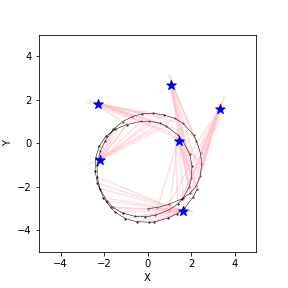

In [37]:
ms = {}
for landmark_id in zlist_landmark:
    edges = []
    head_z = zlist_landmark[landmark_id][0]
    for z in zlist_landmark[landmark_id]:
        edges.append(MapEdge(z[0], z[1][1], head_z[0], head_z[1][1], hat_xs))
        
    ms[landmark_id] = np.mean([e.m for e in edges], axis=0)

draw(hat_xs, zlist, edges, ms)